# keras_net_dev

Developing the CNN in Keras/Theano.

In [1]:
# A bit of setup

# Usual imports
import time
import numpy as np
import os
import matplotlib.pyplot as plt

# Notebook plotting magic
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# For auto-reloading external modules
%load_ext autoreload
%autoreload 2

# My modules
import generate_data as d

def rel_error(x, y):
    """ Returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8. np.abs(x) + np.abs(y))))

/home/tim/.local/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


In [2]:
import generate_data # My data function

In [3]:
# Get some small dataset
train, val, test = generate_data.get_data(
    datadir=os.path.abspath('../salami-audio/'),
    salamidir=os.path.abspath('../salami-data-public/'),
    outputdir=os.path.abspath('./bindata/'),
    n_songs_train=1,
    n_songs_val=1,
    n_songs_test=1,
    seed=None
    )

Getting training data
SID: 1455,	file: 1455.mp3
Getting validation data
SID: 1243,	file: 1243.mp3
Getting test data
SID: 1008,	file: 1008.mp3


generate_data.py:242: RuntimeWarning: divide by zero encountered in log10
  sig_feat = 20.0*np.log10( sig_feat ) # convert to dB


In [4]:
# Show our data dictionary
print 'Training data:'
for item in train:
    print '\t', item, ':\t', train[item]

Training data:
	paths :	['1455.mp3']
	audiodir :	/home/tim/Projects/convnet-music-structure/salami-audio
	Xshape :	[28590, 1, 128, 129]
	sids :	[1455]
	datadir :	/home/tim/Projects/convnet-music-structure/src/bindata
	Xfile :	/home/tim/Projects/convnet-music-structure/src/bindata/train1457388919.45_X
	yfile :	/home/tim/Projects/convnet-music-structure/src/bindata/train1457388919.45_y
	frame_start :	[0]
	yshape :	[28590, 1]


In [20]:
# For now, just load in all the data

X_train = np.memmap(
    train['Xfile'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(train['Xshape'])
    )
y_train = np.memmap(
    train['yfile'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(train['yshape'])
    )

X_val = np.memmap(
    val['Xfile'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(val['Xshape'])
    )
y_val = np.memmap(
    val['yfile'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(val['yshape'])
    )

print "Train: ", X_train.shape, y_train.shape
print "Val:   ", X_val.shape,   y_val.shape

Train:  (28590, 1, 128, 129) (28590, 1)
Val:    (21180, 1, 128, 129) (21180, 1)


In [21]:
# Make it even smaller, for debugging
X_train = X_train[512:1024]
y_train = y_train[512:1024]

X_val = X_val[64:128]
y_val = y_val[64:128]

print "Train: ", X_train.shape, y_train.shape
print "Val:   ", X_val.shape,   y_val.shape

Train:  (512, 1, 128, 129) (512, 1)
Val:    (64, 1, 128, 129) (64, 1)


In [22]:
# Is it well behaved?
print "Inf values : ", np.any(np.isinf(X_train))
print "Nan values : ", np.any(np.isnan(X_train))

Inf values :  False
Nan values :  False


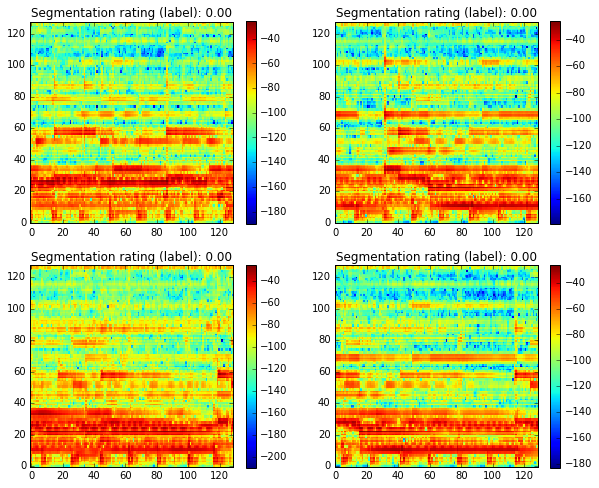

In [23]:
plt.rcParams['image.cmap'] = 'jet'
plt.figure()
for iPlot in xrange(1,5):
    plt.subplot(2,2,iPlot)
    samp = np.random.randint(0,X_train.shape[0])
    plt.imshow(X_train[samp,0], origin="lower")
    plt.colorbar()
    plt.title("Segmentation rating (label): {0:1.2f}".format(y_train[samp,0]))
plt.show()

In [25]:
# Import keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD

# VGG-like convnet, from Keras examples, http://keras.io/examples/
model= Sequential()

reg_amount = 0.01

model.add(Convolution2D(
        16, 3, 3,
        border_mode='valid',
        input_shape=(1, 128, 129),
        init='glorot_normal',
        W_regularizer=l2(reg_amount),
        b_regularizer=l2(reg_amount)
    ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(
        16, 3, 3,
        init='glorot_normal',
        W_regularizer=l2(reg_amount),
        b_regularizer=l2(reg_amount)
    ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(
        16, 3, 3,
        border_mode='valid',
        init='glorot_normal',
        W_regularizer=l2(reg_amount),
        b_regularizer=l2(reg_amount)
    ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(
        16, 3, 3,
        init='glorot_normal',
        W_regularizer=l2(reg_amount),
        b_regularizer=l2(reg_amount)
    ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Note: Keras does automatic shape inference.
model.add(Dense(
        256,
        init='glorot_normal',
        W_regularizer=l2(reg_amount),
        b_regularizer=l2(reg_amount)
    ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(
        1,
        init='glorot_normal',
        W_regularizer=l2(reg_amount),
        b_regularizer=l2(reg_amount)
    ))
model.add(Activation('linear'))

sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='msle', optimizer=sgd)

In [ ]:
# plot the model
from keras.utils.visualize_util import plot
plot(model, to_file='model.png')

In [12]:
from keras.callbacks import ModelCheckpoint
# Callback for model checkpointing
checkpointer = ModelCheckpoint(filepath="./bindata/weights.hdf5", verbose=1, save_best_only=True)

# Callback for loss history
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [28]:
history = LossHistory()

model.reset_states()

model.fit(
    X_train, y_train,
    batch_size=32,
    nb_epoch=1,
    show_accuracy=True,
    verbose=1,
    callbacks=[checkpointer, history],
    validation_data=(X_val, y_val)xlab
    )

Train on 512 samples, validate on 64 samples
Epoch 1/1
512/512 [==============================] - 112s - loss: 6.0146 - acc: 1.0000 - val_loss: 2.5173e-04 - val_acc: 1.0000
Epoch 00000: val_loss did not improve


In [ ]:
for weights in model.get_weights():
    print "===================================="
    print weights

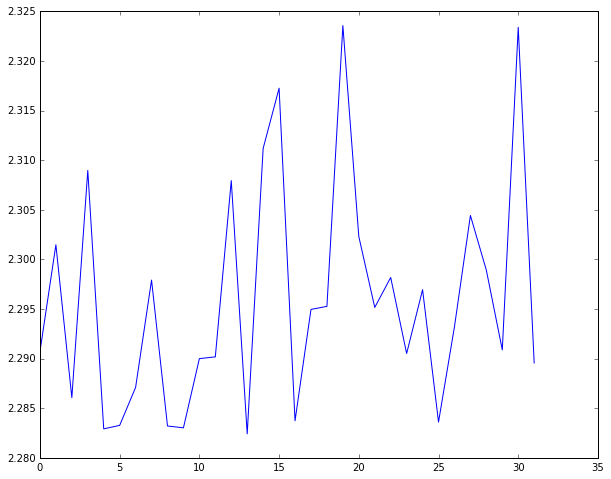

In [14]:
plt.plot(history.losses)

[[-250.         -250.         -250.         ...,  -88.10823059
   -92.28578186  -94.00531769]
 [-250.         -250.         -250.         ...,  -68.20700836
   -72.38455963  -74.10409546]
 [-250.         -250.         -250.         ...,  -55.62841797
   -74.29436493  -69.78768158]
 ..., 
 [-250.         -250.         -250.         ...,  -81.32608795
   -70.88687134  -82.0884552 ]
 [-250.         -250.         -250.         ...,  -78.88808441
   -71.32905579  -73.72687531]
 [-250.         -250.         -250.         ...,  -82.30955505
   -76.84410095  -75.26515961]]


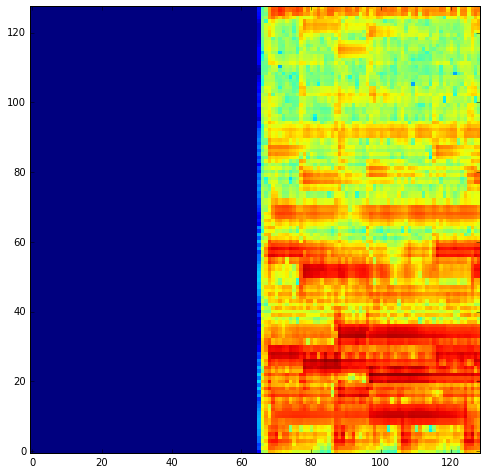

In [15]:
plt.imshow(X_train[0,0],origin="lower")
print X_train[0,0]

In [ ]:
#print X_train[0,0,64]
np.any(np.isinf(X_train))

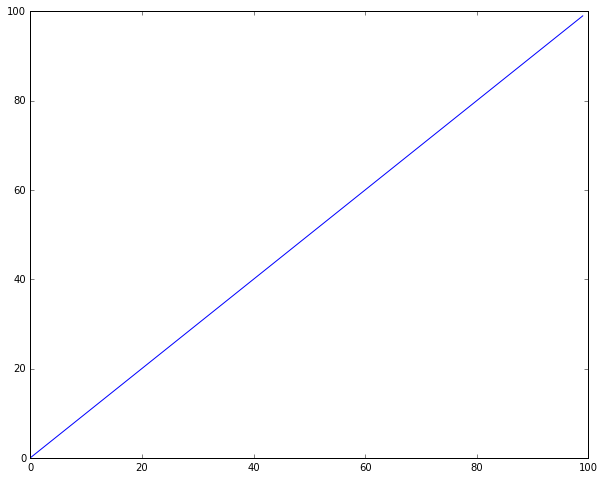

In [27]:
plt.plot(range(100))
